In [93]:
import websocket
import json
import time
import threading
import uuid
import pandas as pd
from datetime import datetime
import logging

class TradingViewDataFetcher:
    def __init__(self, log_level=logging.WARNING):
        """
        Initialize the TradingView data fetcher with configurable logging.
        
        Args:
            log_level: Logging level (default: WARNING to suppress info messages)
        """
        logging.basicConfig(level=log_level, format='%(asctime)s - %(levelname)s - %(message)s')
        self.logger = logging.getLogger(__name__)
        
        # Default WebSocket URL (can be changed if needed)
        self.ws_url = "wss://prodata.tradingview.com/socket.io/websocket"
        
        # Default headers
        self.headers = {
            "Origin": "https://www.tradingview.com",
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
        }

    def fetch_data(self, symbol, exchange="NASDAQ", interval="D", num_bars=100, timeout=20, alt_urls=None):
        """
        Fetch historical price data from TradingView.
        
        Args:
            symbol: Trading symbol (e.g., "AAPL")
            exchange: Exchange name (e.g., "NASDAQ")
            interval: Time interval (e.g., "D" for daily, "W" for weekly, "M" for monthly, 
                     or "1" for 1 minute, "5" for 5 minutes, etc.)
            num_bars: Number of bars to request
            timeout: Maximum time to wait for data in seconds
            alt_urls: List of alternative WebSocket URLs to try if the primary fails
            
        Returns:
            pandas.DataFrame: DataFrame containing OHLCV data
        """
        urls_to_try = [self.ws_url]
        if alt_urls:
            urls_to_try.extend(alt_urls)
        
        for url in urls_to_try:
            self.logger.info(f"Trying WebSocket URL: {url}")
            
            # Reset state for each attempt
            self.session_id = f"qs_{uuid.uuid4().hex[:12]}"
            self.chart_session = f"cs_{uuid.uuid4().hex[:12]}"
            self.received_data = []
            self.error_occurred = False
            
            # Create and start WebSocket
            websocket.enableTrace(False)  # Set to True for verbose WebSocket logs
            ws = websocket.WebSocketApp(
                url,
                header=[f"{k}: {v}" for k, v in self.headers.items()],
                on_open=self._on_open(symbol, exchange, interval, num_bars),
                on_message=self._on_message,
                on_error=self._on_error,
                on_close=self._on_close
            )
            
            wst = threading.Thread(target=ws.run_forever)
            wst.daemon = True
            wst.start()
            
            try:
                # Wait for data
                start_time = time.time()
                while time.time() - start_time < timeout:
                    if self.error_occurred:
                        self.logger.error("Connection error detected, trying next URL if available")
                        break
                    
                    if len(self.received_data) >= num_bars/2:
                        self.logger.info(f"Received sufficient data: {len(self.received_data)} bars")
                        break
                        
                    time.sleep(0.5)
                
                # If we have data, process and return it
                if self.received_data:
                    ws.close()
                    return self._process_data()
                
            except KeyboardInterrupt:
                self.logger.info("Interrupted by user")
            finally:
                ws.close()
        
        # If we get here, all URLs failed
        self.logger.error("Failed to retrieve data from all WebSocket URLs")
        return None

    def _process_data(self):
        """Process the received data into a DataFrame."""
        df = pd.DataFrame(self.received_data)
        if not df.empty:
            df['Date'] = pd.to_datetime(df['Date'], unit='s')
            df = df.sort_values('Date')
            #df.set_index('Date', inplace=True)
            return df
        return None

    def _on_open(self, symbol, exchange, interval, num_bars):
        """Prepare the on_open callback with the required parameters."""
        def on_open_callback(ws):
            self.logger.info("WebSocket connection established")
            
            def run():
                try:
                    self._send_message(ws, "set_auth_token", ["unauthorized_user_token"])
                    time.sleep(0.2)
                    
                    self._send_message(ws, "chart_create_session", [self.chart_session, ""])
                    time.sleep(0.2)
                    
                    self._send_message(ws, "switch_timezone", [self.chart_session, "Etc/UTC"])
                    time.sleep(0.2)
                    
                    full_symbol = f"{exchange}:{symbol}"
                    symbol_payload = json.dumps({"symbol": full_symbol, "adjustment": "splits"})
                    self._send_message(ws, "resolve_symbol", [self.chart_session, "symbol_1", f"={symbol_payload}"])
                    time.sleep(0.2)
                    
                    self._send_message(ws, "create_series", [self.chart_session, "s1", "s1", "symbol_1", interval, num_bars, ""])
                    time.sleep(0.2)
                    
                    self._send_message(ws, "chart_create_study", [self.chart_session, "st1", "st1", "sds_1", full_symbol, interval, num_bars, ""])
                    
                    self.logger.info(f"Requested {num_bars} {interval} bars for {full_symbol}")
                except Exception as e:
                    self.logger.error(f"Error in initialization sequence: {e}")
            
            thread = threading.Thread(target=run)
            thread.daemon = True
            thread.start()
        
        return on_open_callback

    def _send_message(self, ws, method, params):
        """Send a properly formatted message to TradingView WebSocket."""
        try:
            data = json.dumps({"m": method, "p": params})
            message = f"~m~{len(data)}~m~{data}"
            ws.send(message)
            self.logger.debug(f"Sent: {method} - {params[:50]}{'...' if len(str(params)) > 50 else ''}")
        except Exception as e:
            self.logger.error(f"Error sending message {method}: {e}")

    def _on_message(self, ws, message):
        """Handle incoming WebSocket messages."""
        if message == "~h~":
            self.logger.debug("Received heartbeat, sending pong")
            ws.send("~h~")
            return
        
        if not message.startswith("~m~"):
            return
        
        try:
            msg_parts = message.split("~m~")
            for i in range(0, len(msg_parts)):
                if msg_parts[i] and msg_parts[i].isdigit() and i + 1 < len(msg_parts):
                    content = msg_parts[i+1]
                    if content and content.startswith("{"):
                        try:
                            data = json.loads(content)
                            
                            if isinstance(data, dict) and data.get("m") == "timescale_update":
                                self.logger.debug("Found timescale_update message")
                                payload = data.get("p", [])
                                if len(payload) > 1 and isinstance(payload[1], dict):
                                    for series_id, series_data in payload[1].items():
                                        if "s" in series_data and isinstance(series_data["s"], list):
                                            bars_count = len(series_data["s"])
                                            self.logger.debug(f"Found {bars_count} price bars")
                                            
                                            for bar in series_data["s"]:
                                                if "v" in bar and len(bar["v"]) >= 5:
                                                    ts, o, h, l, c = bar["v"][:5]
                                                    volume = bar["v"][5] if len(bar["v"]) > 5 else None
                                                    self.received_data.append({
                                                        "Date": ts,
                                                        "Open": o,
                                                        "High": h,
                                                        "Low": l,
                                                        "Close": c,
                                                        "Volume": volume
                                                    })
                        except json.JSONDecodeError:
                            self.logger.debug(f"Failed to parse JSON: {content[:50]}...")
        except Exception as e:
            self.logger.error(f"Error processing message: {e}")

    def _on_error(self, ws, error):
        """Handle WebSocket errors."""
        self.error_occurred = True
        self.logger.error(f"WebSocket error: {error}")

    def _on_close(self, ws, close_status_code, close_msg):
        """Handle WebSocket connection close."""
        self.logger.debug(f"WebSocket closed: {close_status_code} - {close_msg}")


# Example usage
def get_data(symbol, exchange="NASDAQ", interval="D", bars=5000, log_level=logging.WARNING):
    """
    Simple function to fetch data from TradingView.
    
    Args:
        symbol: Trading symbol (e.g., "AAPL")
        exchange: Exchange name (default: "NASDAQ")
        interval: Time interval (default: "D" for daily)
        bars: Number of bars to request (default: 5000)
        log_level: Logging level (default: WARNING - minimal output)
    
    Returns:
        pandas.DataFrame: DataFrame with OHLCV data or None if failure
    """
    fetcher = TradingViewDataFetcher(log_level=log_level)
    
    # Alternative URLs to try if the primary fails
    alt_urls = [
        "wss://data.tradingview.com/socket.io/websocket",
        "wss://s.tradingview.com/socket.io/websocket"
    ]
    
    return fetcher.fetch_data(
        symbol=symbol,
        exchange=exchange,
        interval=interval,
        num_bars=bars,
        alt_urls=alt_urls
    )
import re 

def occ_to_yahoo(occ):
    """
    Convert OCC option symbol (e.g., TSLA250613P00300000) to Yahoo format (e.g., TSLA250613P300.0).
    Handles tickers of any length and all valid strike formats, always includes one decimal.
    """
    m = re.match(r'^([A-Z0-9]{1,6})(\d{6})([CP])(\d{8})$', occ)
    if not m:
        raise ValueError("Invalid OCC option symbol format")
    symbol, date, opt_type, strike_raw = m.groups()
    strike = int(strike_raw) / 1000
    strike_str = f"{strike:.1f}"  # Always one decimal place

    yahoo = f"{symbol}{date}{opt_type}{strike_str}"
    return yahoo




In [94]:
import yfinance as yf
import pandas as pd
pd.set_option('display.max_rows', None)  # Show all rows

## Fetching options chain for a specific ticker
ticker = "TSLA"
expiry = "2025-06-13"  
##___________________________________________________________________________________________________________________________________________________________________________________
def get_options_chain(symbol):
    stock = yf.Ticker(symbol)
    all_options = []
    for expiry in stock.options:
        chain = stock.option_chain(expiry)
        calls = chain.calls.copy()
        puts = chain.puts.copy()
        calls['type'] = 'call'
        puts['type'] = 'put'
        calls['expiry'] = expiry
        puts['expiry'] = expiry
        all_options.append(calls)
        all_options.append(puts)
    options_chain = pd.concat(all_options, ignore_index=True)
    return options_chain.sort_values(by="expiry", ascending=True)
## Adjusts returned Frame 
df = get_options_chain(ticker)
print(df["expiry"].unique())
print(f"{ticker} Current price : {yf.Ticker(ticker).info['currentPrice']}")
print(f"Exchange : {yf.Ticker(ticker).info['exchange']}")
exchange = yf.Ticker(ticker).info['exchange']
df = df[df["expiry"] == expiry]

df.sort_values(by="strike", ascending=True, inplace=True)
key_cols = ['contractSymbol','lastTradeDate','strike', 'type', 'expiry', 'lastPrice', 'bid', 'ask', 'volume', 'openInterest','impliedVolatility']
df = df[[col for col in key_cols if col in df.columns]]


from IPython.display import display, HTML
html = f"""
<div style='height: 200px; overflow: auto; width: fit-content'>
    <style>
        table {{ border-collapse: collapse; }}
        thead th {{
            position: sticky;
            top: 0;
            background-color: Black;
            z-index: 1;
        }}
    </style>
    {df.to_html(index=False)}
</div>
"""



['2025-06-13' '2025-06-20' '2025-06-27' '2025-07-03' '2025-07-11'
 '2025-07-18' '2025-07-25' '2025-08-15' '2025-09-19' '2025-10-17'
 '2025-11-21' '2025-12-19' '2026-01-16' '2026-03-20' '2026-06-18'
 '2026-09-18' '2026-12-18' '2027-01-15' '2027-06-17' '2027-12-17']
TSLA Current price : 308.58
Exchange : NMS


In [95]:
contract = 'TSLA250613C00305000' # change for contracts
##___________________________________________________________________________________________________________________________________________________________________________________

tvcontract = occ_to_yahoo(contract)  # Convert OCC to Yahoo format
data = get_data(tvcontract, exchange="OPRA", interval="1", bars=5000)

data
print(tvcontract)


TSLA250613C305.0


In [96]:
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data.index = data.index - pd.Timedelta(hours=4)
data.tail(10)

,Open,High,Low,Close,Volume
Date,,,,,
2025-06-09 15:50:00,12.30,12.30,12.05,12.15,35.0
2025-06-09 15:51:00,12.35,12.85,12.35,12.85,614.0
2025-06-09 15:52:00,12.85,12.85,12.45,12.45,116.0
2025-06-09 15:53:00,12.32,12.32,11.90,12.05,105.0
2025-06-09 15:54:00,11.95,12.01,11.40,12.01,273.0
2025-06-09 15:55:00,11.80,12.05,11.65,11.90,74.0
2025-06-09 15:56:00,11.85,11.87,11.56,11.75,76.0
2025-06-09 15:57:00,11.80,11.83,11.60,11.65,27.0
2025-06-09 15:58:00,11.74,11.95,11.70,11.95,140.0


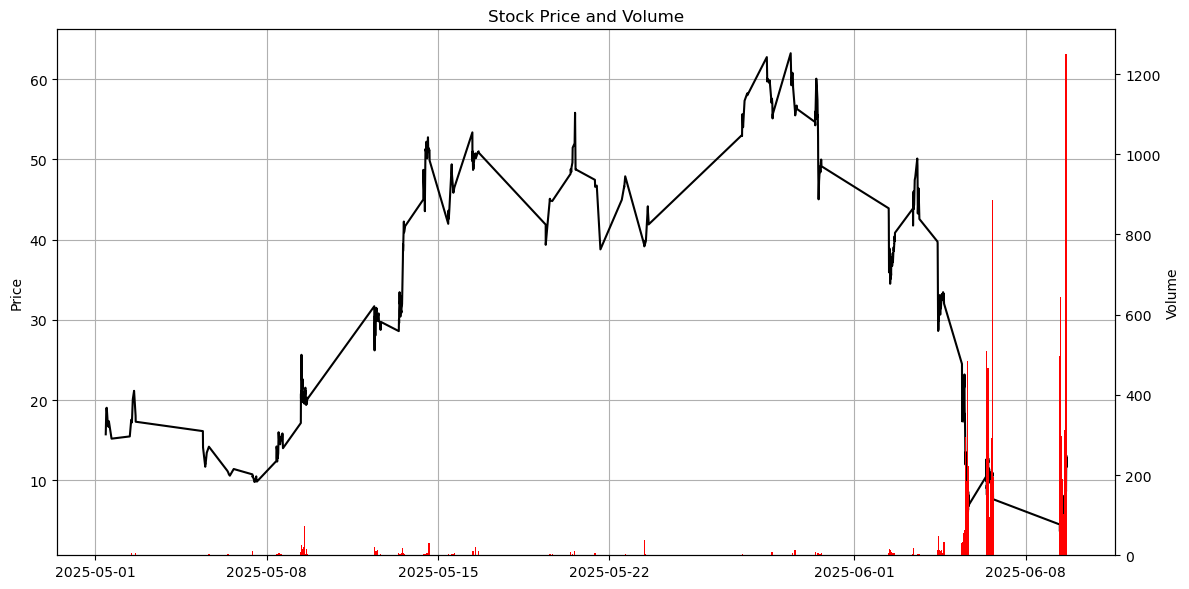

,Open,High,Low,Close,Volume
Date,,,,,
2025-06-09 15:50:00,12.30,12.30,12.05,12.15,35.0
2025-06-09 15:51:00,12.35,12.85,12.35,12.85,614.0
2025-06-09 15:52:00,12.85,12.85,12.45,12.45,116.0
2025-06-09 15:53:00,12.32,12.32,11.90,12.05,105.0
2025-06-09 15:54:00,11.95,12.01,11.40,12.01,273.0
2025-06-09 15:55:00,11.80,12.05,11.65,11.90,74.0
2025-06-09 15:56:00,11.85,11.87,11.56,11.75,76.0
2025-06-09 15:57:00,11.80,11.83,11.60,11.65,27.0
2025-06-09 15:58:00,11.74,11.95,11.70,11.95,140.0


In [97]:

import pandas as pd
import matplotlib.pyplot as plt



import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot closing price
ax1.plot(data.index, data['Close'], color='black', label='Close Price')
ax1.set_ylabel('Price', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_title('Stock Price and Volume')
ax1.grid(True)

# Create a secondary y-axis for volume
ax2 = ax1.twinx()
ax2.bar(data.index, data['Volume'], color='red', alpha=1, label='Volume', width =0.05)
ax2.set_ylabel('Volume', color='black')
ax2.tick_params(axis='y', labelcolor='black')

fig.tight_layout()
plt.show()

data.tail(10)

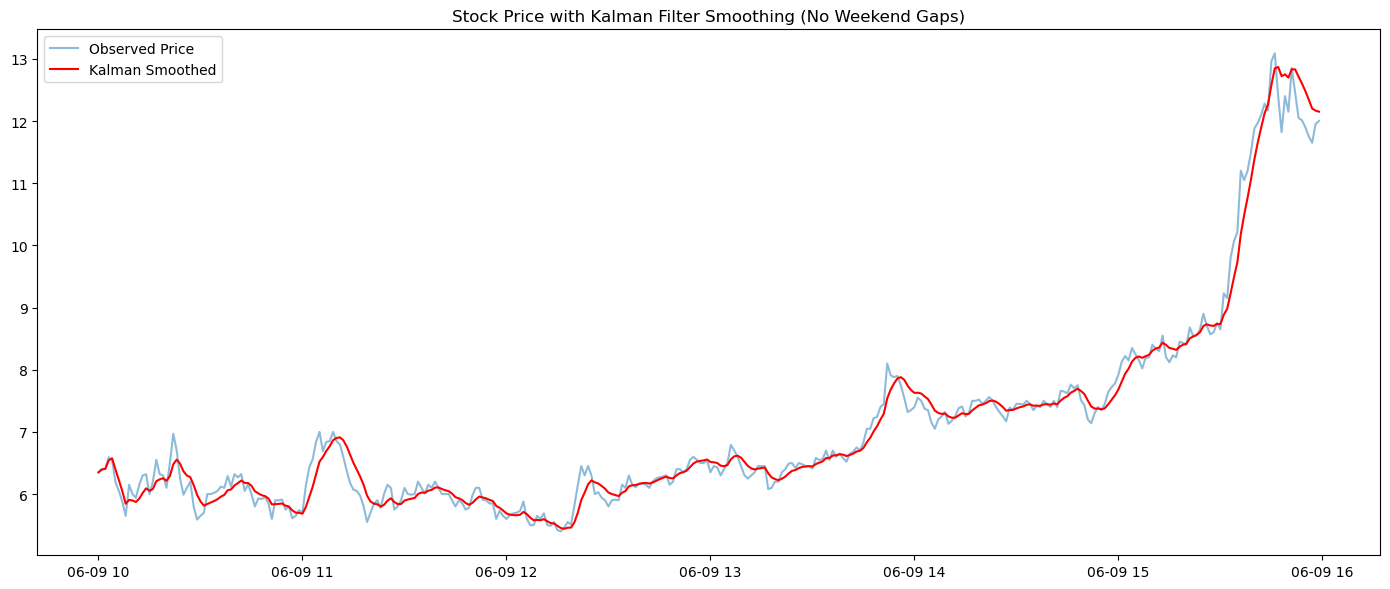

In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from filterpy.kalman import KalmanFilter
##___________________________________________________________________________________________________________________________________________________________________________________
days = 1  # or 7 for a full week
##___________________________________________________________________________________________________________________________________________________________________________________
# --- Data Preparation ---

# Remove weekends and keep only regular trading hours
datafix = data[data.index.weekday < 5]
datafix = datafix[(datafix.index.hour < 16) & (datafix.index.hour > 9)]

# Filter for only the last N days in the data
last_date = datafix.index.max()
timer = last_date - pd.Timedelta(days=days)
datafix = datafix[datafix.index >= timer]

# Ensure index is DatetimeIndex
datafix.index = pd.to_datetime(datafix.index)

# --- Kalman Filter Price ---

kf = KalmanFilter(dim_x=2, dim_z=1)
kf.x = np.array([datafix['Close'].iloc[0], 0.])  # initial state (price, velocity)
kf.F = np.array([[1., .1], [0., 1.]])            # state transition matrix
kf.H = np.array([[1., 0.]])                      # measurement function
kf.P *= 1000.                                    # covariance matrix
kf.R = 1.                                        # measurement noise
kf.Q = np.eye(2)*0.05                            # process noise

filtered_state_means = []
for price in datafix['Close']:
    kf.predict()
    kf.update(price)
    filtered_state_means.append(kf.x[0])

datafix['Kalman'] = filtered_state_means

# --- Plotting ---

plt.figure(figsize=(14,6))
plt.plot(datafix.index, datafix['Close'], label='Observed Price', alpha=0.5)
plt.plot(datafix.index, datafix['Kalman'], label='Kalman Smoothed', color='red')
plt.title('Stock Price with Kalman Filter Smoothing (No Weekend Gaps)')
plt.legend()
plt.tight_layout()
plt.show()


In [99]:
##KALMAN FILTER ROC
datafix["Kalman_Roc"] = datafix['Kalman'].pct_change().dropna() * 100  # Convert to percentage change
datafix.tail(10)

,Open,High,Low,Close,Volume,Kalman,Kalman_Roc
Date,,,,,,,
2025-06-09 15:50:00,12.30,12.30,12.05,12.15,35.0,12.697685,-0.409136
2025-06-09 15:51:00,12.35,12.85,12.35,12.85,614.0,12.834083,1.074195
2025-06-09 15:52:00,12.85,12.85,12.45,12.45,116.0,12.828825,-0.040962
2025-06-09 15:53:00,12.32,12.32,11.90,12.05,105.0,12.711834,-0.911943
2025-06-09 15:54:00,11.95,12.01,11.40,12.01,273.0,12.602528,-0.859876
2025-06-09 15:55:00,11.80,12.05,11.65,11.90,74.0,12.481677,-0.958944
2025-06-09 15:56:00,11.85,11.87,11.56,11.75,76.0,12.341958,-1.119394
2025-06-09 15:57:00,11.80,11.83,11.60,11.65,27.0,12.201400,-1.138863
2025-06-09 15:58:00,11.74,11.95,11.70,11.95,140.0,12.166864,-0.283042


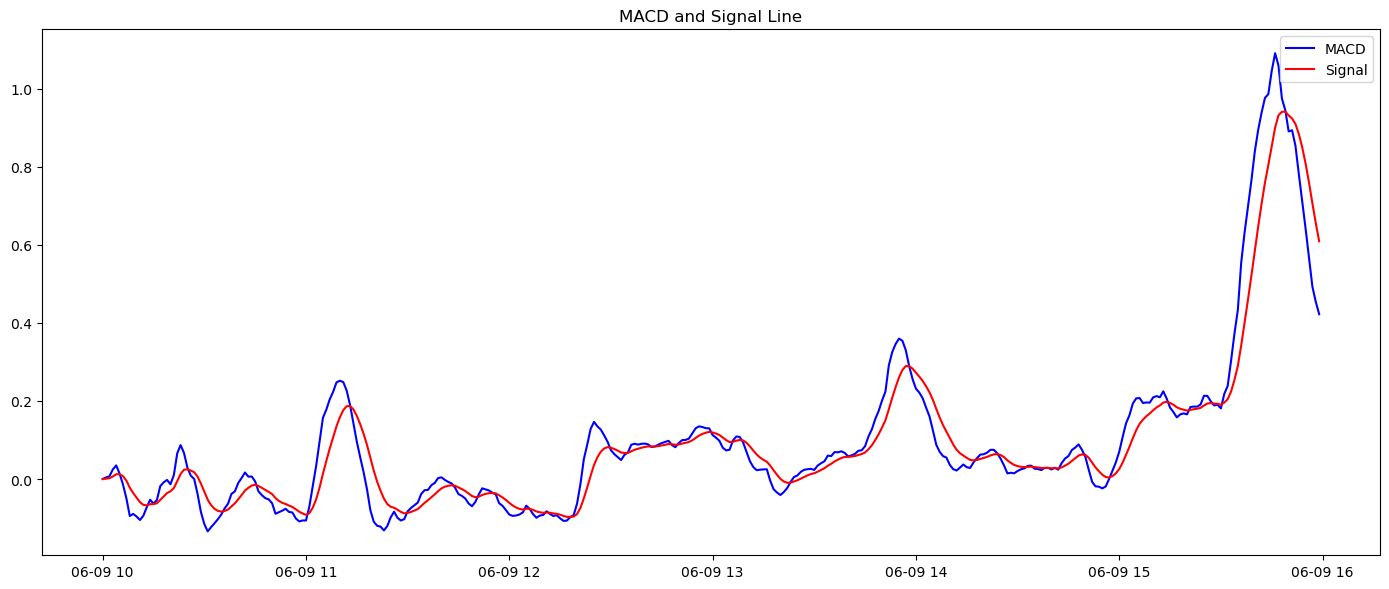

,Open,High,Low,Close,Volume,Kalman,Kalman_Roc,MACD,Signal,MACD_Hist
Date,,,,,,,,,,
2025-06-09 10:00:00,6.05,6.65,5.95,6.35,644.0,6.350000,NaN,0.000000,0.000000,0.000000
2025-06-09 10:01:00,6.37,6.55,6.15,6.40,220.0,6.395823,0.721622,0.003989,0.000798,0.003191
2025-06-09 10:02:00,6.35,6.50,6.35,6.40,126.0,6.407000,0.174749,0.007068,0.002052,0.005016
2025-06-09 10:03:00,6.35,6.65,6.17,6.59,119.0,6.541877,2.105152,0.024557,0.006553,0.018004
2025-06-09 10:04:00,6.55,6.75,6.50,6.55,293.0,6.574497,0.498644,0.034788,0.012200,0.022588
2025-06-09 10:05:00,6.50,6.50,6.10,6.19,143.0,6.394166,-2.742899,0.013690,0.012498,0.001192
2025-06-09 10:06:00,6.13,6.24,6.00,6.05,94.0,6.224194,-2.658234,-0.014164,0.007166,-0.021330
2025-06-09 10:07:00,6.00,6.00,5.69,5.88,108.0,6.047715,-2.835374,-0.049387,-0.004145,-0.045242
2025-06-09 10:08:00,5.86,5.97,5.60,5.65,104.0,5.843836,-3.371174,-0.094768,-0.022270,-0.072498


In [100]:
#MACD
# Calculate MACD and Signal Line
def calculate_macd(df, close_col='Close', fast=12, slow=26, signal=9):
    ema_fast = df[close_col].ewm(span=fast, adjust=False).mean()
    ema_slow = df[close_col].ewm(span=slow, adjust=False).mean()
    macd = ema_fast - ema_slow
    signal_line = macd.ewm(span=signal, adjust=False).mean()
    macd_hist = macd - signal_line
    df['MACD'] = macd
    df['Signal'] = signal_line
    df['MACD_Hist'] = macd_hist
    return df

macdata = calculate_macd(datafix, close_col='Close', fast=12, slow=26, signal=9)

# Plotting MACD
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

# Split MACD histogram into positive and negative for color distinction
macd_hist = macdata['MACD_Hist']
pos_hist = macd_hist.copy()
neg_hist = macd_hist.copy()
pos_hist[pos_hist < 0] = 0
neg_hist[neg_hist > 0] = 0

import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(macdata.index, macdata['MACD'], label='MACD', color='blue')
plt.plot(macdata.index, macdata['Signal'], label='Signal', color='red')
plt.title('MACD and Signal Line')
plt.legend()
plt.tight_layout()
plt.show()

macdata.head(10)


In [101]:
import pandas as pd
print(tvcontract)
## adjusting strike price for the contract

import pandas_datareader.data as web
import datetime

start = datetime.datetime(2024, 1, 1)
end = datetime.datetime(2025, 6, 9)

# DGS1MO is the FRED code for the 1-Month Treasury Constant Maturity Rate
rate = web.DataReader('DGS1MO', 'fred', start, end)
rfr = rate.iloc[-1, 0]  # Last available value as a scalar



TSLA250613C305.0


In [102]:

dateexpiry = "2025-06-13"
expiry = pd.Timestamp(dateexpiry)
datafix['days_to_expiry'] = expiry - datafix.index
print(datafix['days_to_expiry'].tail(1))
datafix['days_to_expiry'] = datafix['days_to_expiry'].dt.days.astype(float)

display(HTML(html))
datafix.tail(10)

Date
2025-06-09 15:59:00   3 days 08:01:00
Name: days_to_expiry, dtype: timedelta64[ns]


contractSymbol,lastTradeDate,strike,type,expiry,lastPrice,bid,ask,volume,openInterest,impliedVolatility
TSLA250613C00050000,2025-06-09 15:06:44+00:00,50.0,call,2025-06-13,246.70,257.00,260.05,5.0,21,8.478520
TSLA250613P00050000,2025-06-06 19:44:38+00:00,50.0,put,2025-06-13,0.01,0.00,0.01,1.0,893,4.500004
TSLA250613C00055000,2025-06-06 19:47:13+00:00,55.0,call,2025-06-13,240.50,252.00,255.05,20.0,12,8.029302
TSLA250613P00055000,2025-06-06 19:14:42+00:00,55.0,put,2025-06-13,0.01,0.00,0.01,20.0,69,4.250005
TSLA250613C00060000,2025-06-04 14:49:05+00:00,60.0,call,2025-06-13,272.03,247.00,250.05,2.0,6,7.625000
TSLA250613P00060000,2025-06-09 15:57:12+00:00,60.0,put,2025-06-13,0.01,0.00,0.01,9.0,16287,4.125005
TSLA250613P00065000,2025-06-06 19:46:23+00:00,65.0,put,2025-06-13,0.01,0.00,0.01,11.0,56614,3.875000
TSLA250613C00065000,2025-06-04 14:49:05+00:00,65.0,call,2025-06-13,267.05,242.00,245.05,2.0,4,7.255860
TSLA250613C00070000,2025-06-06 17:14:32+00:00,70.0,call,2025-06-13,230.77,237.00,240.05,1.0,3,6.917970
TSLA250613P00070000,2025-06-09 19:35:14+00:00,70.0,put,2025-06-13,0.01,0.00,0.01,14.0,22354,3.750001


,Open,High,Low,Close,Volume,Kalman,Kalman_Roc,MACD,Signal,MACD_Hist,days_to_expiry
Date,,,,,,,,,,,
2025-06-09 15:50:00,12.30,12.30,12.05,12.15,35.0,12.697685,-0.409136,0.890416,0.931304,-0.040888,3.0
2025-06-09 15:51:00,12.35,12.85,12.35,12.85,614.0,12.834083,1.074195,0.893459,0.923735,-0.030276,3.0
2025-06-09 15:52:00,12.85,12.85,12.45,12.45,116.0,12.828825,-0.040962,0.853753,0.909739,-0.055986,3.0
2025-06-09 15:53:00,12.32,12.32,11.90,12.05,105.0,12.711834,-0.911943,0.781005,0.883992,-0.102986,3.0
2025-06-09 15:54:00,11.95,12.01,11.40,12.01,273.0,12.602528,-0.859876,0.711918,0.849577,-0.137659,3.0
2025-06-09 15:55:00,11.80,12.05,11.65,11.90,74.0,12.481677,-0.958944,0.640903,0.807842,-0.166940,3.0
2025-06-09 15:56:00,11.85,11.87,11.56,11.75,76.0,12.341958,-1.119394,0.565994,0.759473,-0.193479,3.0
2025-06-09 15:57:00,11.80,11.83,11.60,11.65,27.0,12.201400,-1.138863,0.492877,0.706154,-0.213276,3.0
2025-06-09 15:58:00,11.74,11.95,11.70,11.95,140.0,12.166864,-0.283042,0.453907,0.655704,-0.201797,3.0


In [103]:
# get stock price


## Get the exchange correct from tradingview
stockdata = get_data(ticker, exchange="NASDAQ", interval="1", bars=5000)




In [112]:
import pandas as pd

# Ensure both DataFrames' datetime columns are in datetime format
stockdata['Date'] = pd.to_datetime(stockdata['Date'])
datafix.index = pd.to_datetime(datafix.index)

# Sort both DataFrames by their datetime columns
stockdata = stockdata.sort_values('Date')
datafix = datafix.sort_index()

# Get the first datetime from stockdata
first_stock_date = stockdata['Date'].iloc[0]

# Replace the first index value in datafix with the first datetime from stockdata
new_index = datafix.index.to_list()
new_index[0] = first_stock_date
datafix.index = pd.to_datetime(new_index)

# Now the first datetime value in datafix matches the first in stockdata
datafix.head(10)
datafix = datafix.iloc[1:]

KeyError: 'Date'

In [105]:
import pandas as pd

# Ensure datetime columns and indices are in the correct format
stockdata['Date'] = pd.to_datetime(stockdata['Date'])
datafix.index = pd.to_datetime(datafix.index)

# Sort both DataFrames by date
stockdata = stockdata.sort_values('Date').set_index('Date')
datafix = datafix.sort_index()

# Filter stockdata to only keep rows with dates present in datafix's index
stockdata_filtered = stockdata[stockdata.index.isin(datafix.index)]

# Merge on the index, keeping only matching dates
datafix = pd.merge(
    datafix,
    stockdata_filtered[['Close']],
    left_index=True,
    right_index=True,
    how='inner'
)

# Rename 'Close' to 'stock price'
datafix = datafix.rename(columns={'Close': 'stock price'})

# Preview the result
# Rename Close_x to Close and Close_y to stock price
datafix = datafix.rename(columns={'Close_x': 'Close', 'Close_y': 'stock price'})

# Preview the result
datafix.head(10)



,Open,High,Low,Close,Volume,Kalman,Kalman_Roc,MACD,Signal,MACD_Hist,days_to_expiry,stock price
2025-05-21 14:40:00,6.05,6.65,5.95,6.35,644.0,6.350000,NaN,0.000000,0.000000,0.000000,3.0,343.850
2025-06-09 13:30:00,6.40,6.41,6.40,6.41,2.0,6.442499,-0.103374,0.023335,0.014852,0.008482,3.0,286.140
2025-06-09 13:31:00,6.45,6.58,6.45,6.58,21.0,6.481965,0.612585,0.034483,0.018778,0.015704,3.0,282.060
2025-06-09 13:32:00,6.61,6.61,6.50,6.55,24.0,6.504926,0.354231,0.040431,0.023109,0.017322,3.0,284.050
2025-06-09 13:33:00,6.55,6.60,6.55,6.56,29.0,6.525321,0.313535,0.045428,0.027573,0.017855,3.0,282.940
2025-06-09 13:34:00,6.56,6.75,6.52,6.70,83.0,6.578035,0.807840,0.059993,0.034057,0.025936,3.0,284.920
2025-06-09 13:35:00,6.67,6.67,6.50,6.55,9.0,6.579439,0.021337,0.058755,0.038996,0.019759,3.0,283.495
2025-06-09 13:36:00,6.55,6.70,6.55,6.70,26.0,6.619605,0.610475,0.069082,0.045013,0.024068,3.0,285.620
2025-06-09 13:37:00,6.68,6.75,6.60,6.60,30.0,6.624216,0.069669,0.068408,0.049692,0.018715,3.0,284.860
2025-06-09 13:38:00,6.65,6.70,6.65,6.65,27.0,6.640376,0.243949,0.071089,0.053972,0.017117,3.0,285.190


In [106]:
print(tvcontract)

TSLA250613C305.0


In [107]:



# set strike for black scholes 
datafix['strike'] = 350
datafix['rfr'] = rfr/100
# Define the type of option
datafix["type"] = "c"
##___________________________________________________________________________________________________________________________________________________________________________________



import numpy as np
from scipy.stats import norm
from scipy.optimize import brentq

def black_scholes_price(S, K, T, r, sigma, option_type='c'):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == 'c':
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    else:
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

def implied_volatility_row(row):
    price = row['Close']
    S = row['stock price']
    K = row['strike']
    T = row['days_to_expiry'] / 365.0
    r = row['rfr']
    option_type = row['type']  # 'c' for call, 'p' for put

    # Objective function for root finding
    def objective(sigma):
        return black_scholes_price(S, K, T, r, sigma, option_type) - price

    try:
        return brentq(objective, 1e-6, 5.0)
    except Exception:
        return np.nan

datafix['IV'] = datafix.apply(implied_volatility_row, axis=1)



In [108]:
datafix["IVROC"] = datafix["IV"].pct_change().dropna() * 100  # Convert to percentage change
datafix.head(10)

,Open,High,Low,Close,Volume,Kalman,Kalman_Roc,MACD,Signal,MACD_Hist,days_to_expiry,stock price,strike,rfr,type,IV,IVROC
2025-05-21 14:40:00,6.05,6.65,5.95,6.35,644.0,6.350000,NaN,0.000000,0.000000,0.000000,3.0,343.850,350,0.0428,c,0.721192,NaN
2025-06-09 13:30:00,6.40,6.41,6.40,6.41,2.0,6.442499,-0.103374,0.023335,0.014852,0.008482,3.0,286.140,350,0.0428,c,2.375893,229.439594
2025-06-09 13:31:00,6.45,6.58,6.45,6.58,21.0,6.481965,0.612585,0.034483,0.018778,0.015704,3.0,282.060,350,0.0428,c,2.513193,5.778860
2025-06-09 13:32:00,6.61,6.61,6.50,6.55,24.0,6.504926,0.354231,0.040431,0.023109,0.017322,3.0,284.050,350,0.0428,c,2.453265,-2.384518
2025-06-09 13:33:00,6.55,6.60,6.55,6.56,29.0,6.525321,0.313535,0.045428,0.027573,0.017855,3.0,282.940,350,0.0428,c,2.485732,1.323408
2025-06-09 13:34:00,6.56,6.75,6.52,6.70,83.0,6.578035,0.807840,0.059993,0.034057,0.025936,3.0,284.920,350,0.0428,c,2.449275,-1.466667
2025-06-09 13:35:00,6.67,6.67,6.50,6.55,9.0,6.579439,0.021337,0.058755,0.038996,0.019759,3.0,283.495,350,0.0428,c,2.468803,0.797325
2025-06-09 13:36:00,6.55,6.70,6.55,6.70,26.0,6.619605,0.610475,0.069082,0.045013,0.024068,3.0,285.620,350,0.0428,c,2.429620,-1.587132
2025-06-09 13:37:00,6.68,6.75,6.60,6.60,30.0,6.624216,0.069669,0.068408,0.049692,0.018715,3.0,284.860,350,0.0428,c,2.437409,0.320574
2025-06-09 13:38:00,6.65,6.70,6.65,6.65,27.0,6.640376,0.243949,0.071089,0.053972,0.017117,3.0,285.190,350,0.0428,c,2.434939,-0.101337


In [109]:
# Ensure your index is a DatetimeIndex
datafix.index = pd.to_datetime(datafix.index)

# Filter for weekdays (Monday=0, Sunday=6)
is_weekday = datafix.index.dayofweek < 5

# Filter for regular trading hours (9:30 to 16:00)
is_regular_hours = (
    (datafix.index.hour > 9) & (datafix.index.hour < 16) |  # 10:00 to 15:59
    ((datafix.index.hour == 9) & (datafix.index.minute >= 30)) |  # 9:30 to 9:59
    ((datafix.index.hour == 16) & (datafix.index.minute == 0))    # exactly 16:00
)

# Combine masks
mask = is_weekday & is_regular_hours

# Apply mask to keep only regular trading hours
datafix = datafix.loc[mask]


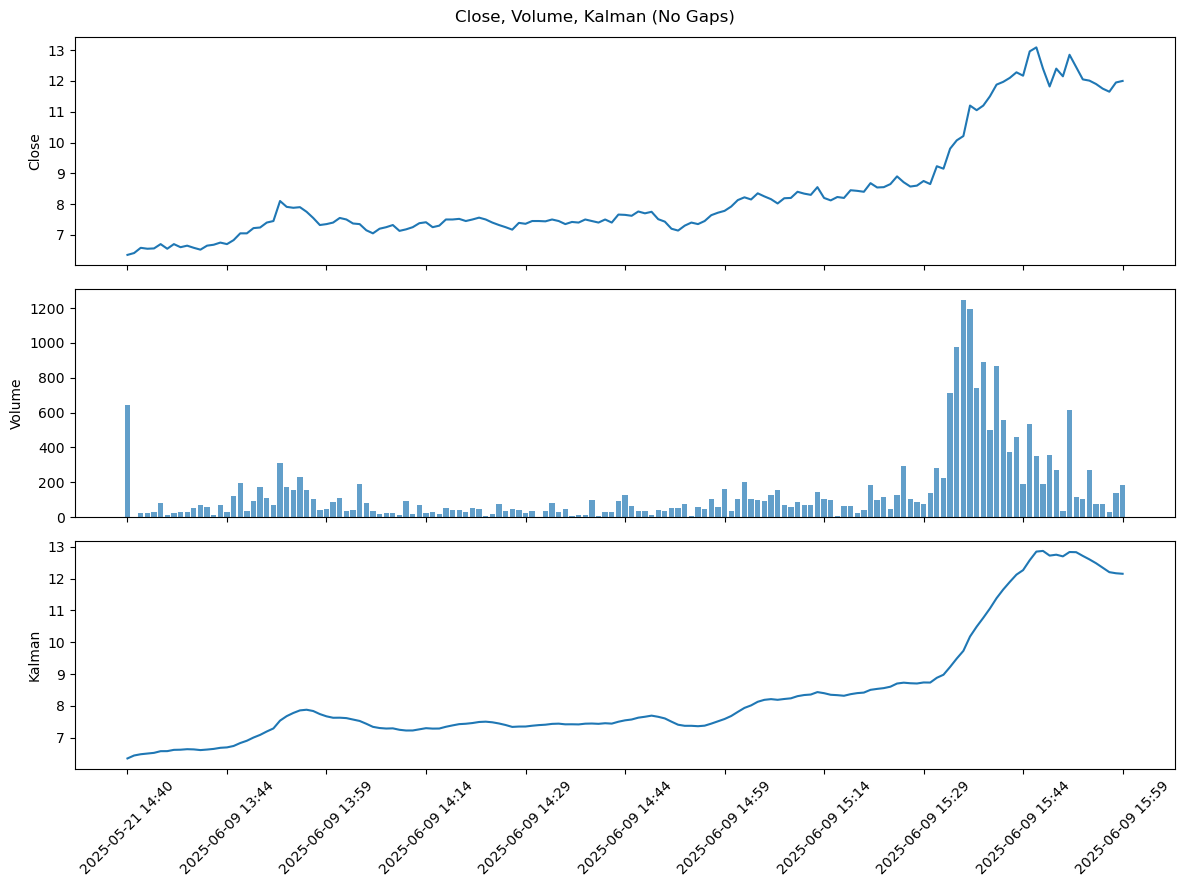

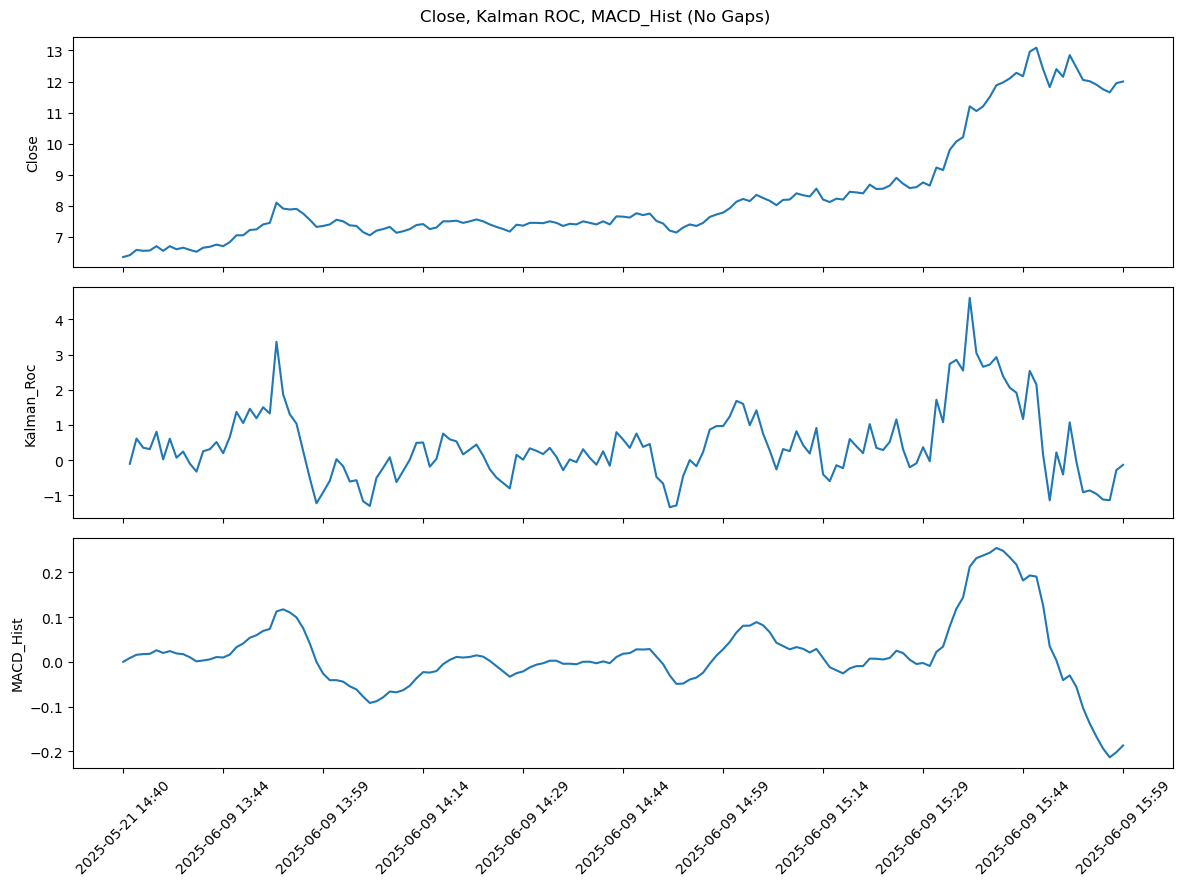

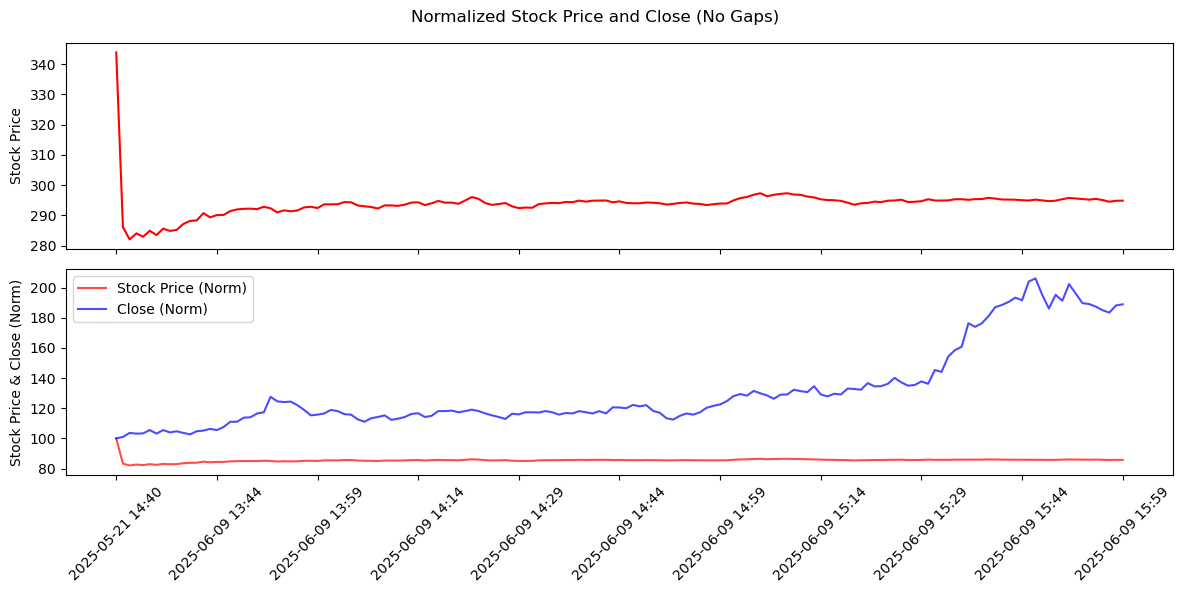

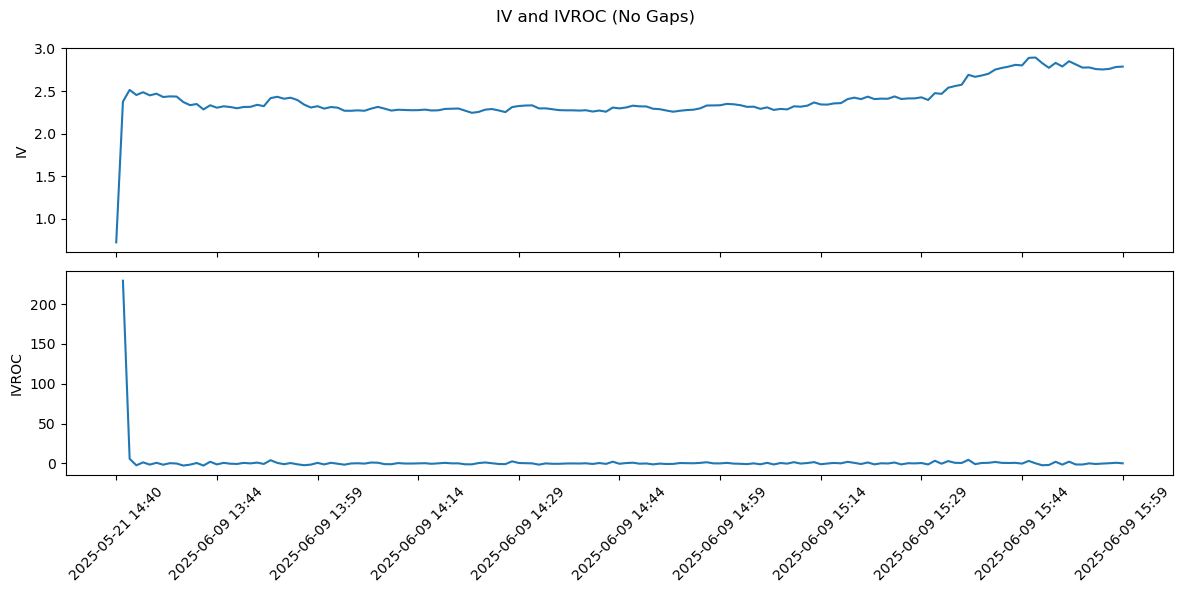

In [110]:
import matplotlib.pyplot as plt

# Reset index and detect the datetime column name
datafix_reset = datafix.reset_index()
datetime_col = datafix_reset.columns[0]  # The first column after reset_index() is always the old index

# For tick labeling, use the datetime column
time_labels = datafix_reset[datetime_col]

# Function to plot with integer index and datetime tick labels
def plot_with_int_index(y_cols, suptitle, kinds=None):
    n = len(y_cols)
    fig, axs = plt.subplots(n, 1, figsize=(12, 3*n), sharex=True)
    if n == 1:
        axs = [axs]
    for i, col in enumerate(y_cols):
        kind = 'line' if not kinds else kinds[i]
        if kind == 'bar':
            axs[i].bar(datafix_reset.index, datafix_reset[col], label=col, alpha=0.7)
        else:
            axs[i].plot(datafix_reset.index, datafix_reset[col], label=col)
        axs[i].set_ylabel(col)
    # Set x-ticks with datetime labels
    step = max(1, len(time_labels) // 10)
    axs[-1].set_xticks(datafix_reset.index[::step])
    axs[-1].set_xticklabels([t.strftime('%Y-%m-%d %H:%M') for t in time_labels[::step]], rotation=45)
    plt.suptitle(suptitle)
    plt.tight_layout()
    plt.show()

# 1. Close, Volume (bar), Kalman
plot_with_int_index(['Close', 'Volume', 'Kalman'], 'Close, Volume, Kalman (No Gaps)', kinds=['line', 'bar', 'line'])

# 2. Close, Kalman_Roc, MACD_Hist (bar)
plot_with_int_index(['Close', 'Kalman_Roc', 'MACD_Hist'], 'Close, Kalman ROC, MACD_Hist (No Gaps)', kinds=['line', 'line', 'line'])
import pandas as pd
from sklearn.preprocessing import StandardScaler
#3. Prices
# Normalize 'stock price' and 'Close' to start at 100
datafix_reset['stock price (norm)'] = datafix_reset['stock price'] / datafix_reset['stock price'].iloc[0] * 100
datafix_reset['Close (norm)'] = datafix_reset['Close'] / datafix_reset['Close'].iloc[0] * 100

# Overlay plot: normalized stock price and close
fig, axs = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
axs[0].plot(datafix_reset.index, datafix_reset['stock price'], label='Stock Price ', color='red')
axs[0].set_ylabel('Stock Price')
axs[1].plot(datafix_reset.index, datafix_reset['stock price (norm)'], label='Stock Price (Norm)', color='red', alpha=0.7)
axs[1].plot(datafix_reset.index, datafix_reset['Close (norm)'], label='Close (Norm)', color='blue', alpha=0.7)
axs[1].set_ylabel('Stock Price & Close (Norm)')
axs[1].legend()
step = max(1, len(time_labels) // 10)
axs[1].set_xticks(datafix_reset.index[::step])
axs[1].set_xticklabels([t.strftime('%Y-%m-%d %H:%M') for t in time_labels[::step]], rotation=45)
plt.suptitle('Normalized Stock Price and Close (No Gaps)')
plt.tight_layout()
plt.show()


# 4. IV, IVROC
plot_with_int_index(['IV', 'IVROC'], 'IV and IVROC (No Gaps)')
